# SHAP Values Analysis

SHAP (SHapley Additive exPlanations) estimates how much each input feature contributes to a prediction by assigning an importance value called a Shapley value. This value shows how much the feature pushes the model’s output away from or toward a baseline (usually the average prediction).

In this notebook, we analyze SHAP values generated for our drug synergy prediction models (Biomining, TranSynergy).

In [1]:
import sys
from pathlib import Path
import os 

# Assuming this notebook is in: explainability/notebooks/
# So we go two levels up to reach the root where 'explainability/' lives
project_root = Path.cwd().parents[1]  # cwd = explainability/notebooks/
sys.path.append(str(project_root))
os.chdir(project_root)

In [7]:
from explainability.shap.utils import load_shap_data

bio_shap_values, bio_inputs, bio_feature_names = load_shap_data("biomining")
tran_shap_values, tran_inputs, tran_feature_names = load_shap_data("transynergy")

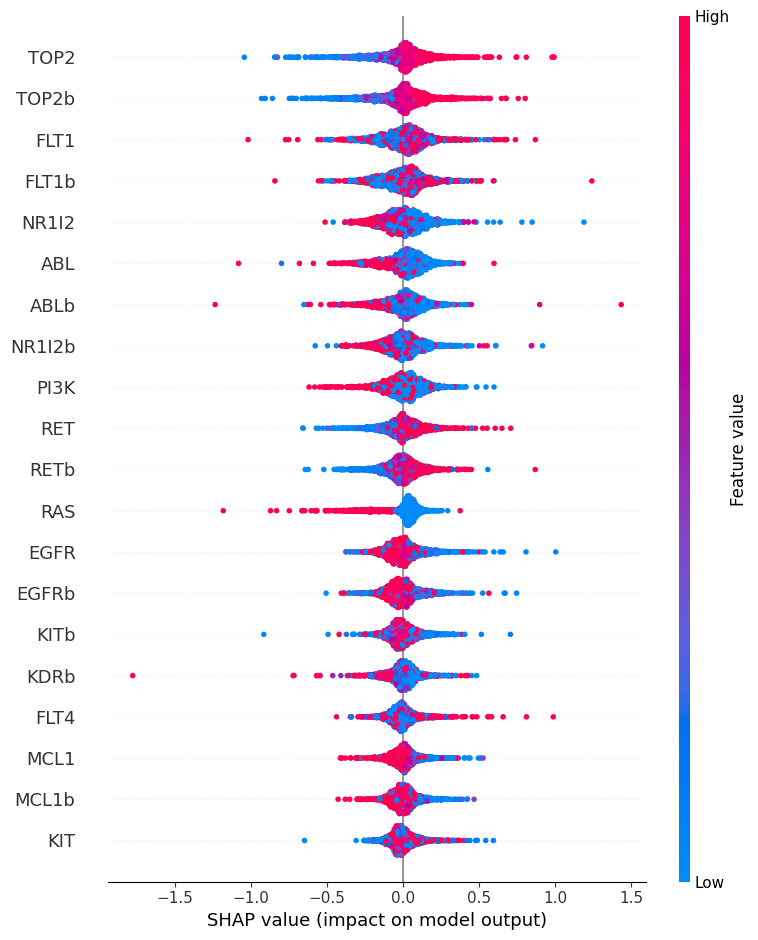

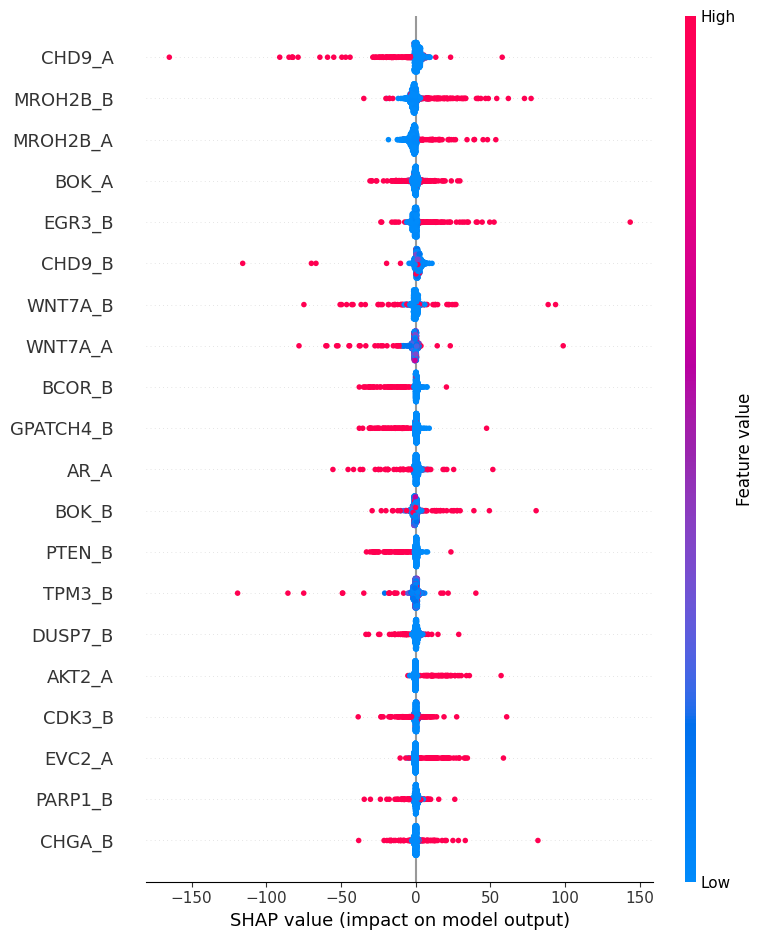

In [8]:
import shap
import matplotlib.pyplot as plt

shap.summary_plot(bio_shap_values, bio_inputs, bio_feature_names)
shap.summary_plot(tran_shap_values, tran_inputs, tran_feature_names)
plt.show()



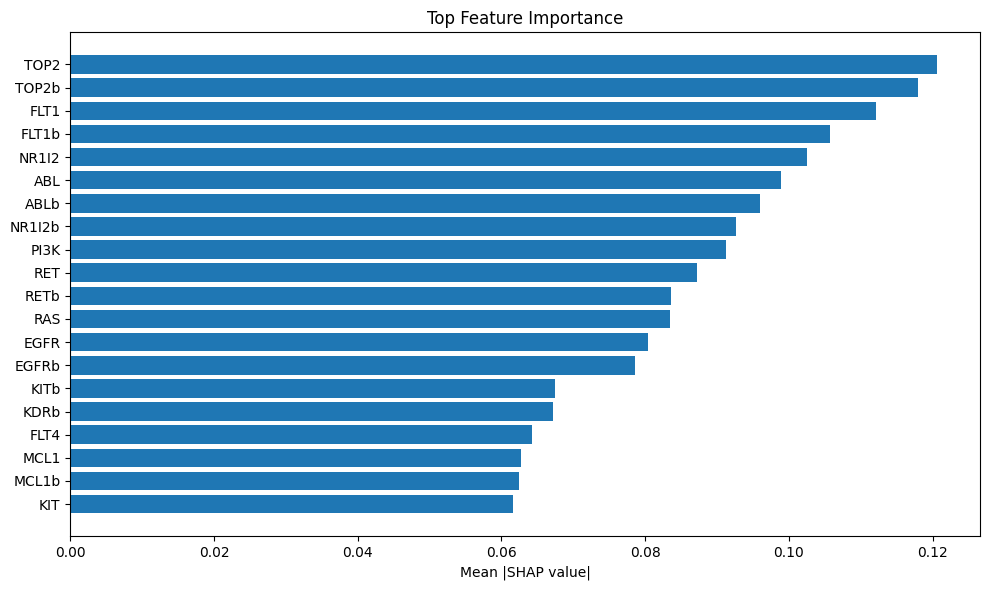

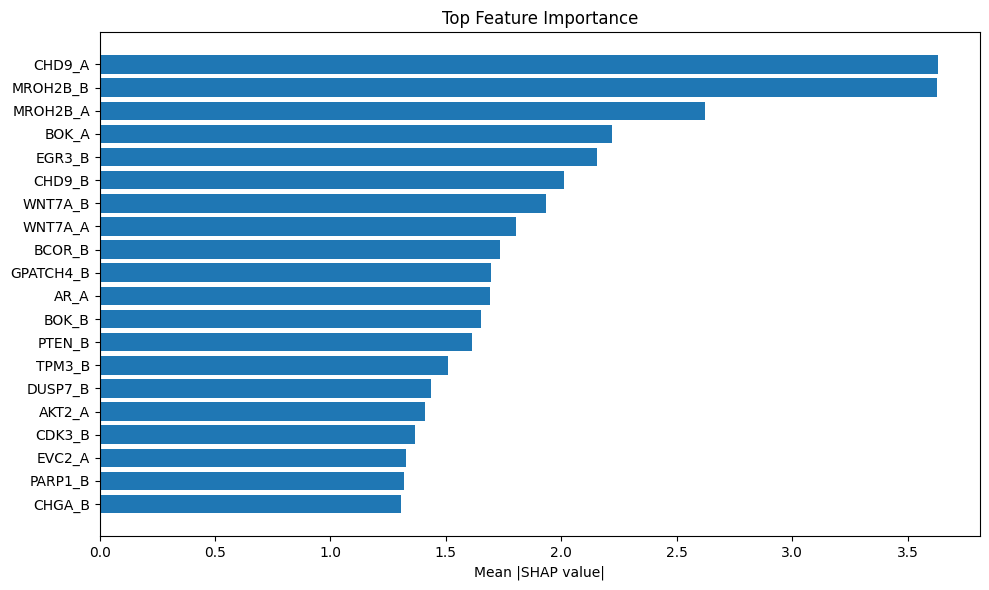

In [9]:
import numpy as np
import pandas as pd

def plot_feature_importance(shap_values, feature_names, top_n=20):
    mean_abs_shap = np.mean(np.abs(shap_values), axis=0)
    importance_df = pd.DataFrame({
        "feature": feature_names,
        "mean_abs_shap": mean_abs_shap
    }).sort_values(by="mean_abs_shap", ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    plt.barh(importance_df["feature"][::-1], importance_df["mean_abs_shap"][::-1])
    plt.xlabel("Mean |SHAP value|")
    plt.title("Top Feature Importance")
    plt.tight_layout()
    plt.show()

plot_feature_importance(bio_shap_values, bio_feature_names)
plot_feature_importance(tran_shap_values, tran_feature_names)



Dependence plot for Biomining feature: TOP2


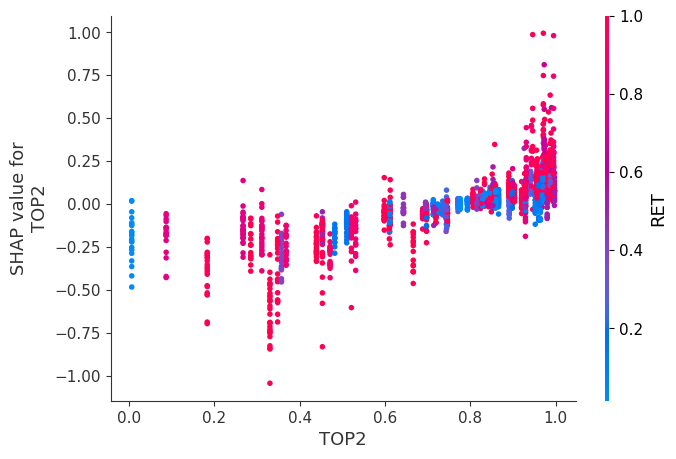

Dependence plot for Biomining feature: TOP2b


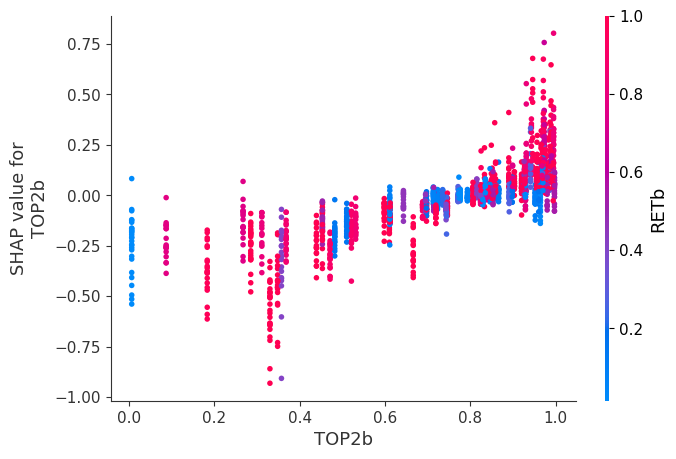

Dependence plot for Biomining feature: FLT1


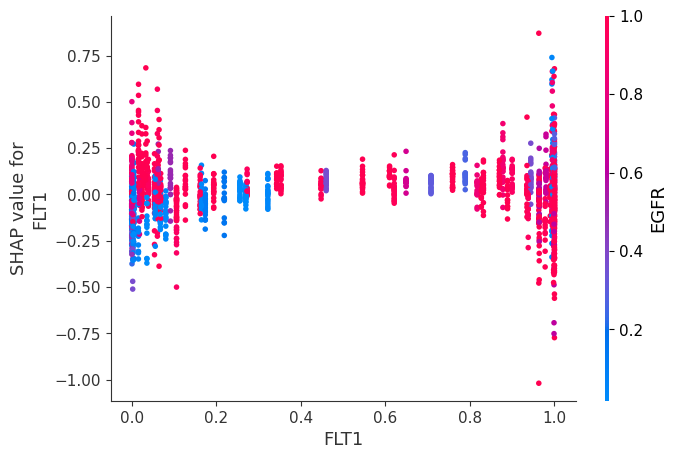

Dependence plot for TranSynergy feature: CHD9_A


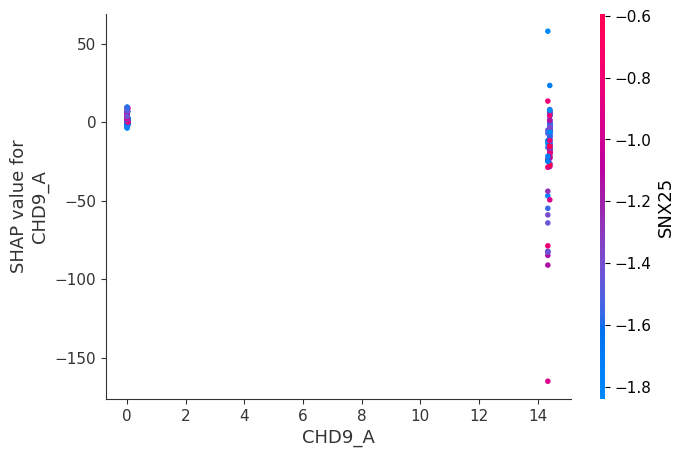

Dependence plot for TranSynergy feature: MROH2B_B


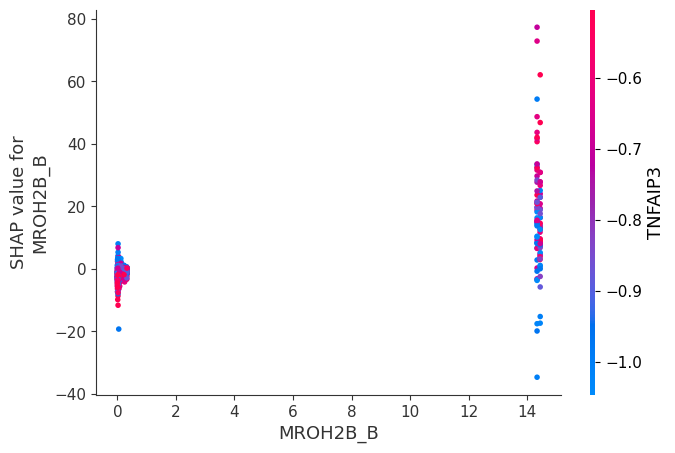

Dependence plot for TranSynergy feature: MROH2B_A


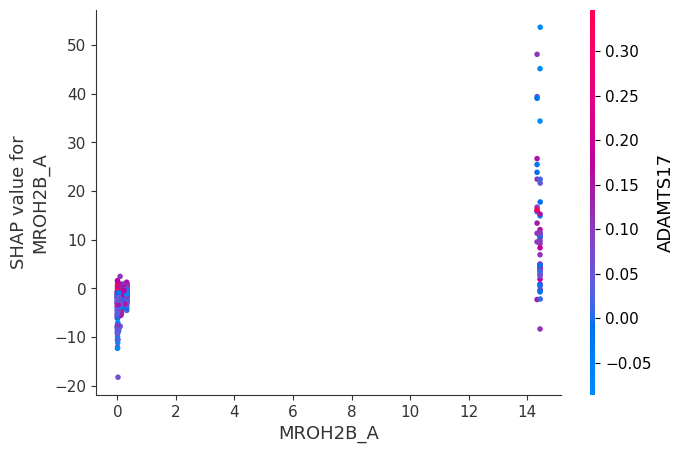

In [14]:
def get_top_features(shap_values, feature_names, top_n=3):
    mean_abs_shap = np.mean(np.abs(shap_values), axis=0)
    sorted_indices = np.argsort(mean_abs_shap)[::-1]
    top_features = [feature_names[i] for i in sorted_indices[:top_n]]
    return top_features

top3_bio = get_top_features(bio_shap_values, bio_feature_names, top_n=3)
top3_tran = get_top_features(tran_shap_values, tran_feature_names, top_n=3)

for feat in top3_bio:
    print(f"Dependence plot for Biomining feature: {feat}")
    shap.dependence_plot(feat, bio_shap_values, bio_inputs, feature_names=bio_feature_names)
    plt.show()

for feat in top3_tran:
    print(f"Dependence plot for TranSynergy feature: {feat}")
    shap.dependence_plot(feat, tran_shap_values, tran_inputs, feature_names=tran_feature_names)
    plt.show()
